In [1]:
import torch
import os
import numpy as np
import pandas as pd
import torch
import torchmetrics
import random
import torchvision
from tqdm import tqdm
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset
from torchvision import transforms
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score
from torch import nn
from PIL import Image
from torchvision.models import efficientnet_b3

BATCH_SIZE = 28
NUM_WORKERS = 2
RESIZING = 224

if torch.cuda.is_available():
    DEVICE = torch.device('cuda')
    print('Using GPU:', torch.cuda.get_device_name(0))
else:
    DEVICE = torch.device('cpu')
    print('No GPU, Using CPU instead')

Using GPU: Tesla T4


Достанем данные из папки и посчитаем, какая выборка у нас получилась

In [4]:
def get_images(path):
    image_names_lst = os.listdir(path)
    train_df, test_df = pd.read_csv(path + '/train.csv'), pd.read_csv(path + '/test.csv')
    train_df.sort_values(by='image_id', ignore_index=True, inplace=True)
    image_names = sorted(os.listdir(path + '/train/'))
    train_images, test_images = [path + '/train/' + name for name in image_names], [path + '/test/' + name for name in os.listdir(path + '/test/')]
    labels = list(train_df['label'].values)
    return train_images, test_images, labels

train_images, test_images, labels = get_images('/kaggle/input/vk-made-sports-image-classification')
print('Train dataset:', len(train_images),', number of classes', len(np.unique(labels)), 'test dataset', len(test_images))

Train dataset: 45373 , number of classes 30 test dataset 19446


В описании сказано, что придется что-то делать с датасетом. Значит, данные не самые хорошие и классы не сбалансированы. Посчитаем всю выборку и посмотрим, какие классы в меньшенстве

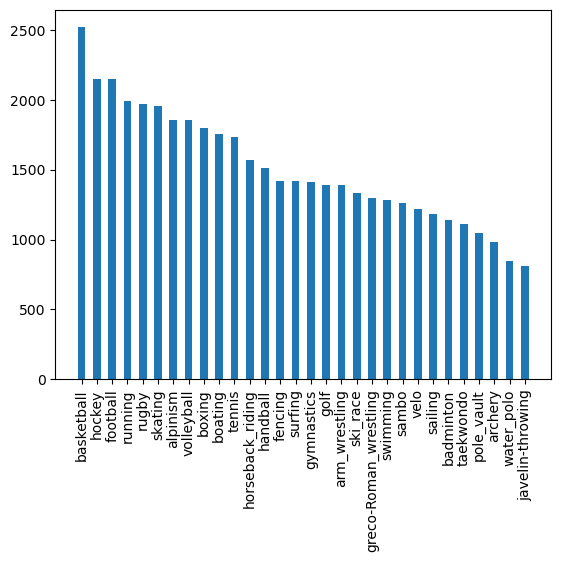

In [5]:
cnt = Counter(labels)
cnt_sorted = [(k, v) for k, v in sorted(cnt.items(), reverse=True, key=lambda x:x[1])]
sorted_labels = [pair[0] for pair in cnt_sorted]
sorted_values = [pair[1] for pair in cnt_sorted]
plt.bar(sorted_labels,  sorted_values, width=0.5)
plt.xticks(rotation=90);

Да, действительно, видим, что некоторые классы по количеству значительно отличаются от других. В любом случае, нам нужно будет проконтролировать, чтобы данные из маленьких классов попадали в обучающую и валидационные выборки. Для начала подготовим все к обучению модели, закодируем лейблы

In [6]:
# Преобразуем уникальные классы в id, который будем предсказывать, далее закодируем трейн выборку 
def label_encode(labels):
    unique_labels = np.unique(labels)
    class_to_id = {cls: i for (cls, i) in zip(unique_labels, range(len(unique_labels)))}
    id_to_class = {i : cls for (i, cls) in zip(range(len(unique_labels)), unique_labels)}    
    return class_to_id, id_to_class

# воспользуемся функцией для просмотра картинок тренировочного даталоадера из лекции 
# https://github.com/lysukhin/vk-academy-dl-cv/tree/2022/computer_vision
def imshow(inp, title=None, figsize=(16, 9)):
    """Imshow for Tensor."""
    plt.figure(figsize=figsize)
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.5, 0.5, 0.5])
    std = np.array([0.5, 0.5, 0.5])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001) 

Так как данные не сбалансированы по классам, первая идея - это взять одинаковое количество данных из каждого класса, которое нам позволяет самый маленький по численности класс, а для классов с количество картинок больше - возьмем чуть больше картинок. Из предыдущего блока мы узнали, что в наименьшем классе около 800-820 изображений, ограничим количество картинок в каждом из классов 1000-1100, тогда в малых классах мы возьмем все имеющиеся картинки, а в больших - сколько получится. Также одной из идей улучшения процесса обучения модели было - написать функцию, которая будет "подкладывать" новые картинки в даталоадер каждые несколько эпох. Это решение кажется оптимальным в случае, если набор картинок у нас в целом большой, но вся выборка не помещается в один даталоадер. Это показалось наилучшим решением в случае, когда увеличение числа картинок как и увеличение самих картинок (размер RESIZING) грозит нам долгой работой модели, а более сложная модель будет переобучаться или обучаться слишком долго.
Напишем такую функцию и протестируем ее. До этого лучший скор ограничивался f1 = 0.90, с такой функцией f1 дошел до 0.92

In [27]:
from sklearn.utils import shuffle
def get_train_dataset(data, class_size):
    cnts = [0 for i in range(len(class_to_id))] # будем контролировать попадание классов с помощью этого счетчика
    df = data[data.group=='Pilot'].copy()
    df['flg'] = 0
    df = shuffle(df)
    df.reset_index(inplace=True)
    for i in range(len(df)):
        img = df.name.iloc[i]
        lbl = df.labels.iloc[i]
        cond = df.name == img
        if cnts[lbl] <= class_size:
            cnts[lbl] += 1
            df.loc[cond, ['flg']] = 1
    return df


original_labels = labels
class_to_id, id_to_class = label_encode(labels)
labels = [class_to_id[label] for label in labels]
data = pd.DataFrame(train_images, columns=['name']) # dataset with all information
data['labels'] = labels
data['group'] = 'Pilot'

df = get_train_dataset(data, 1100)
downsampled_train_images = list(df[df.flg == 1].name)
downsampled_train_labels = list(df[df.flg == 1].labels)
len(downsampled_train_labels)

32316

In [33]:
data.groupby(by='group').count()

,name,labels
group,,
Pilot,45373,45373


Посмотрим, как теперь выглядит наша выборка классов в одном сампле картинок. Таким способом формирования датасета мы должны были получить все картинки из малых классов ( а это 800-820 картинок, то есть все) и рандомно отобранные картинки других классов до 1100 штук. Вот так выглядит наша итоговая обучающая выборка классов

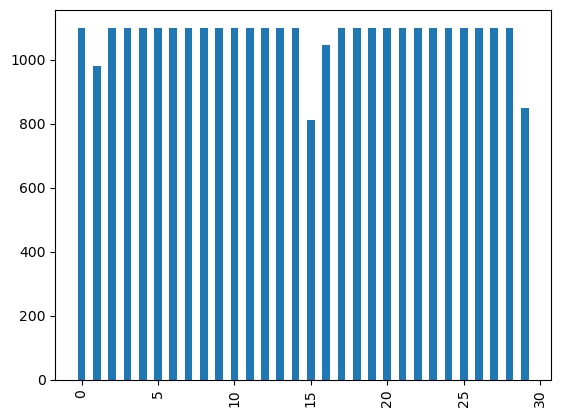

In [34]:
cnt = Counter(downsampled_train_labels)
cnt_sorted = [(k, v) for k, v in sorted(cnt.items(), reverse=True, key=lambda x:x[1])]
sorted_labels = [pair[0] for pair in cnt_sorted]
sorted_values = [pair[1] for pair in cnt_sorted]
plt.bar(sorted_labels,  sorted_values, width=0.5)
plt.xticks(rotation=90);

Подготовим данные для обучения модели - создадим тренировочную и валидационную выборки из размеченных картинок и пометим их флагом пилота или контрольной группы для картинок трейна и валидации. Картинки валидации будут четко зафиксированы - они не должны попасть в обучающую выборку даже при пересоздании обучающего датасета нашей функцией.

In [36]:
train_imgs, val_imgs, train_labels, val_labels = train_test_split(downsampled_train_images, downsampled_train_labels, test_size=0.25, random_state=1234)
# Размечаем наш датасет, чтобы потом не перепутать валидационную и тренировочные выборки 

for img in val_imgs:
    cond_df = df.name == img
    cond_data = data.name == img
    df.loc[cond_df, ['group']] = 'CG'
    data.loc[cond_data, ['group']] = 'CG'
    
print(len(train_imgs), len(val_imgs))

24237 8079


In [37]:
data.groupby(by='group').count()

,name,labels
group,,
CG,8079,8079
Pilot,37294,37294


Проверим, что наш способ разметки картинок работает - попробуем пересоздать выборку 

In [38]:
df = get_train_dataset(data, 1100)
downsampled_train_images = list(df[df.flg == 1].name)
downsampled_train_labels = list(df[df.flg == 1].labels)
len(downsampled_train_labels)

30198

In [49]:
data.groupby(by='group').count()

,name,labels
group,,
CG,8079,8079
Pilot,37294,37294


In [50]:
class TochDataset(Dataset):
    def __init__(self, image_paths, labels, transform_composed=None):
        self.img_paths = image_paths
        self.labels = labels
        self.transforms = transform_composed
    def __len__(self):
        return len(self.img_paths)
    
    def __getitem__(self, idx):
        label = self.labels[idx]
        img_path = self.img_paths[idx]
        img = Image.open(img_path).convert('RGB')
        img_tensor = self.transforms(img)
        return {
            'image': img_tensor, 
            'label': torch.tensor(label).long()
        }

Так как нам нужно побить довольно высокий бейзлайн добавим побольше аугментаций! Начнем с тех, которые использовались в лекциях, будем проверять, как выглядят картинки, чтобы случайно не испортить процесс обучения модели. Кажется, что все аугментации можно представить в реальной жизни - например, спортсмен может быть снят под разными ракурсами, под разным наклоном - добавляем поворот картинок и горизонтальное отображение. На всякий случай добавим еще и черно-белый фильтр, такие картинки тоже могут встретиться. Или же, например, условия съемки могут быть такими, будто фотография уже в чб - например темная фигура альпиниста на фоне белого снега или же фото в контровом свете. Так как мы будем использовать предобученную модель b3, добавим сразу же ресайзинг картинок под подходящий размер (указан в спецификации к модели).

In [51]:
train_transforms = transforms.Compose([
    transforms.Resize((RESIZING, RESIZING)),
    transforms.ColorJitter(brightness=0.1, contrast=0.1,saturation=0.1),
    transforms.RandomRotation((-10, 10)),
    transforms.RandomHorizontalFlip(0.3), 
    transforms.RandomGrayscale(0.2),
    transforms.ToTensor(), 
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
val_transforms = transforms.Compose([
    transforms.Resize((RESIZING, RESIZING)),
    transforms.ToTensor(), 
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_dataset = TochDataset(train_imgs, train_labels, transform_composed = train_transforms)
val_dataset = TochDataset(val_imgs, val_labels, transform_composed = val_transforms)

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, num_workers = NUM_WORKERS, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, num_workers = NUM_WORKERS, shuffle=False)

Так как мы использовали много аугментаций, посмотрим, как они повлияли на картинки - действительно ли картинки различимы. Если что можем подправить аугментации, но кажется, что картинки вполне читаемы

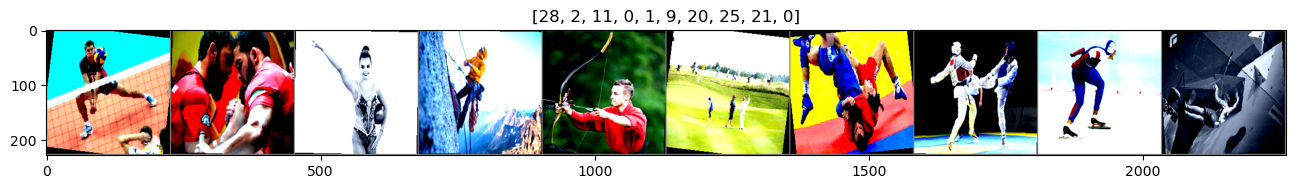

In [52]:
class_names = train_dataset.labels
show = next(iter(train_dataloader))
out = torchvision.utils.make_grid(show['image'][:10], nrow=10)
imshow(out, title=[id_to_class[x] for x in list(np.array(show['label']))[:10]])

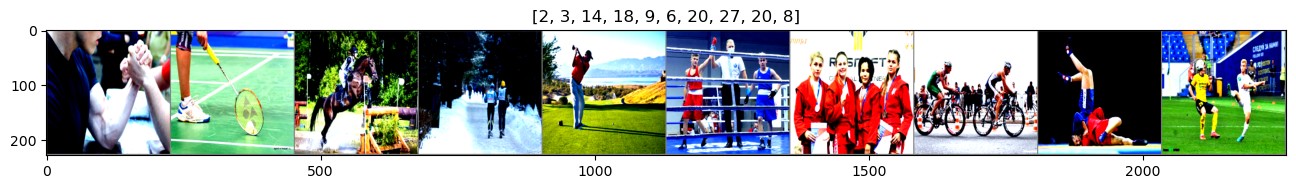

In [53]:
class_names = val_dataset.labels
show = next(iter(val_dataloader))
out = torchvision.utils.make_grid(show['image'][:10], nrow=10)
imshow(out, title=[id_to_class[x] for x in list(np.array(show['label']))[:10]])

Напишем скрипты для обучения модели. Так как модель предобученная, нам не нужно будет обучать ее всю, обучаться должен только последний слой, попробуем это отобразить в том числе в коде.

In [54]:
def train_one_epoch(model, train_dataloader, optimizer, criterion):
    train_losses = 0
    model.train()
    # хоть модель и перевели в режим обучения, веса предобученной модели не должны меняться
    for module in model.modules():
        module.requires_grad = False
    model.fc.requires_grad = True
    
    all_preds = []
    for data in tqdm(train_dataloader):
        imgs, labels = data['image'], data['label']
        imgs, labels = imgs.to(DEVICE), labels.to(DEVICE)
        optimizer.zero_grad()
        y_pred = model(imgs)
        loss = criterion(y_pred, labels)
        train_losses += loss.item()
        loss.backward()
        optimizer.step()
        all_preds.append(y_pred)
    train_epoch_loss = train_losses / len(train_dataloader) # ошибка на всей выборке
    return all_preds, train_epoch_loss

def predict(model, val_dataloader, criterion):
    pred_losses = 0
    losses, all_preds = [], []
    model.eval()
    with torch.no_grad():
        for data in tqdm(val_dataloader):
            imgs, labels = data['image'], data['label']
            imgs, labels =  imgs.to(DEVICE), labels.to(DEVICE)
            y_pred = model(imgs)
            loss = criterion(y_pred, labels)
            pred_losses += loss.item()
            all_preds.append(y_pred)
    val_epoch_loss = pred_losses / len(val_dataloader)
    return all_preds, val_epoch_loss

Размер линейного слоя также взят из спецификации модели. Приступим к обучению

In [55]:
model = torchvision.models.efficientnet_b3(weights='EfficientNet_B3_Weights.IMAGENET1K_V1')
model.fc = nn.Linear(in_features=1536, out_features=len(class_to_id)) # TODO 1536 for model b3

Приступим к обучению нашей модели, каждые 5 эпох будем менять трейн выборку - собирать новые картинки из всего датасет рандомно, причем постараемся не допускать лики данных

In [56]:
# from sklearn.metrics import f1_score

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.3, patience=3, verbose=True)
criterion = nn.CrossEntropyLoss()
EPOCHS = 35
model.to(DEVICE)

for epoch in range(EPOCHS):        
    answers_val = []
    answers_train = []
    
    t_pred, t_los = train_one_epoch(model, train_dataloader, optimizer, criterion)
    v_pred, v_los = predict(model, val_dataloader, criterion)
    for vp in v_pred:
        vp = list(torch.argmax(torch.softmax(vp.cpu(), 1), 1).numpy())
        answers_val.extend(vp) 
    
    f1 = f1_score(val_labels, answers_val, average='micro')
    acc_val = round(accuracy_score(answers_val, val_labels), 4)    
    learn_rate = optimizer.state_dict()['param_groups'][0]['lr']
    print(f'Epoch: {epoch}, train_loss={t_los}, valid_loss={v_los}, f1={f1}, val_accuracy={acc_val}, lr={learn_rate}')
    scheduler.step(v_los)
    
    if epoch % 5 == 0 and epoch > 0:
        print('Changing train dataset')
        df = get_train_dataset(data, 1100)
        train_images = list(df[df.flg == 1].name)
        train_labels = list(df[df.flg == 1].labels)
        train_dataset = TochDataset(train_images, train_labels, transform_composed = train_transforms)
        train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, num_workers = NUM_WORKERS, shuffle=True)  

100%|██████████| 289/289 [00:48<00:00,  5.95it/s]


Epoch: 0, train_loss=1.1319535862628638, valid_loss=0.6117457750037467, f1=0.8320336675331106, val_accuracy=0.832, lr=0.001


100%|██████████| 289/289 [00:53<00:00,  5.40it/s]


Epoch: 1, train_loss=0.6492591973385552, valid_loss=0.49624050585198565, f1=0.8634732021289764, val_accuracy=0.8635, lr=0.001


100%|██████████| 289/289 [01:04<00:00,  4.51it/s]


Epoch: 2, train_loss=0.5285064241145555, valid_loss=0.48983293452064885, f1=0.8704047530634981, val_accuracy=0.8704, lr=0.001


100%|██████████| 289/289 [00:48<00:00,  5.96it/s]


Epoch: 3, train_loss=0.45910695361244486, valid_loss=0.46345916340146925, f1=0.8808020794652803, val_accuracy=0.8808, lr=0.001


100%|██████████| 289/289 [00:45<00:00,  6.36it/s]


Epoch: 4, train_loss=0.4124253551211148, valid_loss=0.5280710784653943, f1=0.8617403143953459, val_accuracy=0.8617, lr=0.001


100%|██████████| 289/289 [00:49<00:00,  5.80it/s]


Epoch: 5, train_loss=0.36516141147174236, valid_loss=0.5183690621108332, f1=0.8654536452531254, val_accuracy=0.8655, lr=0.001
Changing train dataset


100%|██████████| 289/289 [00:45<00:00,  6.32it/s]


Epoch: 6, train_loss=0.4292930420470856, valid_loss=0.4272865192919557, f1=0.8860007426661716, val_accuracy=0.886, lr=0.001


100%|██████████| 289/289 [00:48<00:00,  5.90it/s]


Epoch: 7, train_loss=0.3593610795102565, valid_loss=0.4478931316661175, f1=0.8827825225894295, val_accuracy=0.8828, lr=0.001


100%|██████████| 289/289 [00:45<00:00,  6.31it/s]


Epoch: 8, train_loss=0.318270502805337, valid_loss=0.45540270367218344, f1=0.889342740438173, val_accuracy=0.8893, lr=0.001


100%|██████████| 289/289 [00:45<00:00,  6.29it/s]


Epoch: 9, train_loss=0.29098534106559176, valid_loss=0.4494852907101666, f1=0.8909518504765442, val_accuracy=0.891, lr=0.001


100%|██████████| 289/289 [00:59<00:00,  4.86it/s]


Epoch: 10, train_loss=0.2582064035436634, valid_loss=0.4986078265319646, f1=0.87906919173165, val_accuracy=0.8791, lr=0.001
Epoch 00011: reducing learning rate of group 0 to 5.0000e-04.
Changing train dataset


100%|██████████| 289/289 [00:47<00:00,  6.08it/s]


Epoch: 11, train_loss=0.1940518718577949, valid_loss=0.3726628058981537, f1=0.909394727070182, val_accuracy=0.9094, lr=0.0005


100%|██████████| 289/289 [00:47<00:00,  6.05it/s]


Epoch: 12, train_loss=0.12432540646471313, valid_loss=0.4269547516100782, f1=0.9092709493749226, val_accuracy=0.9093, lr=0.0005


100%|██████████| 289/289 [00:49<00:00,  5.84it/s]


Epoch: 13, train_loss=0.10544015239051131, valid_loss=0.43212048593964136, f1=0.9098898378512192, val_accuracy=0.9099, lr=0.0005


100%|██████████| 289/289 [00:46<00:00,  6.23it/s]


Epoch: 14, train_loss=0.094138808890144, valid_loss=0.4747361772319876, f1=0.9041960638692907, val_accuracy=0.9042, lr=0.0005


100%|██████████| 289/289 [00:46<00:00,  6.18it/s]


Epoch: 15, train_loss=0.08005781655266826, valid_loss=0.4786593431911422, f1=0.90431984156455, val_accuracy=0.9043, lr=0.0005
Epoch 00016: reducing learning rate of group 0 to 2.5000e-04.
Changing train dataset


100%|██████████| 289/289 [00:47<00:00,  6.14it/s]


Epoch: 16, train_loss=0.08771938355231745, valid_loss=0.41455660379656095, f1=0.9178116103478153, val_accuracy=0.9178, lr=0.00025


100%|██████████| 289/289 [00:46<00:00,  6.24it/s]


Epoch: 17, train_loss=0.055064747107419786, valid_loss=0.4484748758599613, f1=0.9152122787473698, val_accuracy=0.9152, lr=0.00025


100%|██████████| 289/289 [00:45<00:00,  6.35it/s]


Epoch: 18, train_loss=0.037501159987224766, valid_loss=0.48651123435678006, f1=0.9143458348805545, val_accuracy=0.9143, lr=0.00025


100%|██████████| 289/289 [00:48<00:00,  5.90it/s]


Epoch: 19, train_loss=0.038330174329370414, valid_loss=0.4941201110589592, f1=0.9154598341378883, val_accuracy=0.9155, lr=0.00025
Epoch 00020: reducing learning rate of group 0 to 1.2500e-04.


100%|██████████| 289/289 [00:47<00:00,  6.14it/s]


Epoch: 20, train_loss=0.02741064758261014, valid_loss=0.4784226124784286, f1=0.9190493873004084, val_accuracy=0.919, lr=0.000125
Changing train dataset


100%|██████████| 289/289 [00:47<00:00,  6.03it/s]


Epoch: 21, train_loss=0.03823716639983123, valid_loss=0.4515993001954749, f1=0.9189256096051491, val_accuracy=0.9189, lr=0.000125


100%|██████████| 289/289 [00:53<00:00,  5.44it/s]


Epoch: 22, train_loss=0.02446657051691305, valid_loss=0.4691812320176997, f1=0.9195444980814457, val_accuracy=0.9195, lr=0.000125


100%|██████████| 289/289 [00:49<00:00,  5.83it/s]


Epoch: 23, train_loss=0.0229115390911214, valid_loss=0.4722581002587091, f1=0.9174402772620374, val_accuracy=0.9174, lr=0.000125
Epoch 00024: reducing learning rate of group 0 to 6.2500e-05.


100%|██████████| 289/289 [00:45<00:00,  6.39it/s]


Epoch: 24, train_loss=0.017436449276914213, valid_loss=0.47200224132413626, f1=0.9197920534719644, val_accuracy=0.9198, lr=6.25e-05


100%|██████████| 289/289 [00:48<00:00,  5.98it/s]


Epoch: 25, train_loss=0.014129114824100557, valid_loss=0.4841613804698043, f1=0.9199158311672236, val_accuracy=0.9199, lr=6.25e-05
Changing train dataset


100%|██████████| 289/289 [00:45<00:00,  6.40it/s]


Epoch: 26, train_loss=0.022752604449171394, valid_loss=0.4869952885374414, f1=0.9195444980814457, val_accuracy=0.9195, lr=6.25e-05


100%|██████████| 289/289 [00:45<00:00,  6.34it/s]


Epoch: 27, train_loss=0.015461569742529803, valid_loss=0.4725798180195563, f1=0.9206584973387796, val_accuracy=0.9207, lr=6.25e-05
Epoch 00028: reducing learning rate of group 0 to 3.1250e-05.


100%|██████████| 289/289 [00:45<00:00,  6.31it/s]


Epoch: 28, train_loss=0.01246627142307622, valid_loss=0.4792439117763084, f1=0.9205347196435202, val_accuracy=0.9205, lr=3.125e-05


100%|██████████| 289/289 [00:45<00:00,  6.31it/s]


Epoch: 29, train_loss=0.012537263575348375, valid_loss=0.4798770556236695, f1=0.9207822750340389, val_accuracy=0.9208, lr=3.125e-05


100%|██████████| 289/289 [00:44<00:00,  6.44it/s]


Epoch: 30, train_loss=0.01103518353191044, valid_loss=0.48349676630182786, f1=0.9226389404629286, val_accuracy=0.9226, lr=3.125e-05
Changing train dataset


100%|██████████| 289/289 [00:45<00:00,  6.29it/s]


Epoch: 31, train_loss=0.014455932144873519, valid_loss=0.48871501402007067, f1=0.9210298304245575, val_accuracy=0.921, lr=3.125e-05
Epoch 00032: reducing learning rate of group 0 to 1.5625e-05.


100%|██████████| 289/289 [00:44<00:00,  6.42it/s]


Epoch: 32, train_loss=0.010162355167317953, valid_loss=0.4787783075944421, f1=0.9210298304245575, val_accuracy=0.921, lr=1.5625e-05


100%|██████████| 289/289 [00:45<00:00,  6.34it/s]


Epoch: 33, train_loss=0.01070981666132957, valid_loss=0.48706142692364957, f1=0.9216487189008541, val_accuracy=0.9216, lr=1.5625e-05


100%|██████████| 289/289 [00:45<00:00,  6.35it/s]


Epoch: 34, train_loss=0.010842423113937644, valid_loss=0.4911817310489084, f1=0.9218962742913727, val_accuracy=0.9219, lr=1.5625e-05


100%|██████████| 289/289 [00:46<00:00,  6.16it/s]


Epoch: 35, train_loss=0.009895217055264893, valid_loss=0.4806567163290323, f1=0.9207822750340389, val_accuracy=0.9208, lr=1.5625e-05
Epoch 00036: reducing learning rate of group 0 to 7.8125e-06.
Changing train dataset


KeyboardInterrupt: 

Мы захотим посмотреть, на каких картинках модель ошибается, поэтому получим предсказания на всем датасете

In [62]:
#  протестируем предсказания модели, которые мы получим
print('Всего в выборке картинок:', len(downsampled_train_images), len(downsampled_train_labels))
all_dataset = TochDataset(downsampled_train_images, downsampled_train_labels, transform_composed=val_transforms)
all_dataloader = DataLoader(all_dataset, batch_size=BATCH_SIZE, num_workers = NUM_WORKERS, shuffle=False)

answers_all = []
a_pred, a_los = predict(model, all_dataloader, criterion)
for vp in a_pred:
    vp = list(torch.argmax(torch.softmax(vp.cpu(), 1), 1).numpy())
    answers_all.extend(vp) 
f1 = f1_score(downsampled_train_labels, answers_all, average='micro')
print(f'f1={f1}')

Всего в выборке картинок: 30198 30198


100%|██████████| 1079/1079 [03:16<00:00,  5.49it/s]


f1=0.9996688522418703


Посмотрим, какие лейблы мы хуже всего предсказываем

In [72]:
# Посмотрим, какие лейблы мы хуже всего предсказываем
result = pd.DataFrame(downsampled_train_labels, columns=['y_true'])
result['y_pred'] = answers_all
result['image'] = downsampled_train_images
top_5_wrong = list(result[result.y_true != result.y_pred].y_true.value_counts()[:5].index)
print('Классы, на которых модель чаще всего ошибается', top_5_wrong, 'их настойщие лейблы', [id_to_class[i] for i in top_5_wrong]) 

Классы, на которых модель чаще всего ошибается [28, 21, 19, 0, 20] их настойщие лейблы ['volleyball', 'skating', 'sailing', 'alpinism', 'sambo']


In [73]:
result[result.y_true != result.y_pred].y_true.value_counts()

28    3
21    2
19    2
0     1
20    1
18    1
Name: y_true, dtype: int64

In [75]:
wrongs = result[result.y_true != result.y_pred]
wrongs_imgs = list(result[result.y_true != result.y_pred].image)
wrongs_true = list(result[result.y_true != result.y_pred].y_true)
wrongs_pred = list(result[result.y_true != result.y_pred].y_pred)

Кажется, что и не жалко, что модель не может угадать эти классы, так как, очевидно, где-то разметка неверная, а где-то подобранные картинки, которые не особо относятся к спорту с какой-то точки зрения.

Real label 28 volleyball predicted label 18 running


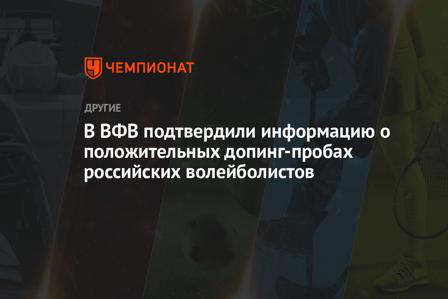

In [80]:
i = 2
print('Real label', wrongs_true[i], id_to_class[wrongs_true[i]], 'predicted label', wrongs_pred[i], id_to_class[wrongs_pred[i]])
Image.open(wrongs_imgs[i]).convert('RGB')

Real label 21 skating predicted label 20 sambo


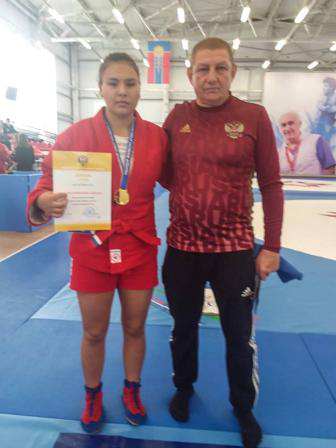

In [79]:
i = 1
print('Real label', wrongs_true[i], id_to_class[wrongs_true[i]], 'predicted label', wrongs_pred[i], id_to_class[wrongs_pred[i]])
Image.open(wrongs_imgs[i]).convert('RGB')

Real label 18 running predicted label 22 ski_race


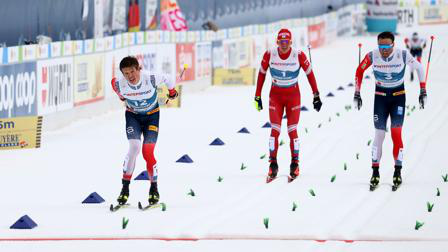

In [82]:
i = 4
print('Real label', wrongs_true[i], id_to_class[wrongs_true[i]], 'predicted label', wrongs_pred[i], id_to_class[wrongs_pred[i]])
Image.open(wrongs_imgs[i]).convert('RGB')

### Завершающая часть - подготовка файла для сабмита

In [57]:
# Делаем предсказание моделью, которое уже пойдет в сабмит - предсказание на тестовой выборке
test_labels = labels[:len(test_images)]
print(len(test_labels), len(test_images))

test_dataset = TochDataset(test_images, test_labels, transform_composed=val_transforms)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, num_workers = NUM_WORKERS, shuffle=False)

test_pred, test_los = predict(model, test_dataloader, criterion)
answers_test = []  

for vp in test_pred:
    vp = list(torch.argmax(torch.softmax(vp.cpu(), 1), 1).numpy())
    answers_test.extend(vp) 

19446 19446


100%|██████████| 695/695 [01:49<00:00,  6.37it/s]


In [58]:
train_images, test_images, labels = get_images('/kaggle/input/vk-made-sports-image-classification')
original_labels = labels
class_to_id, id_to_class = label_encode(labels)
labels = [class_to_id[label] for label in labels]

In [59]:
image_id = [name.split('/')[-1] for name in test_images]
df_sub = pd.DataFrame(image_id, columns=['image_id'])
df_sub['label'] = [id_to_class[answers_test[i]] for i in range(len(answers_test))]
df_sub.head(4)

,image_id,label
0,66f867a8-796c-4e3e-84ad-b55b60d0742d.jpeg,running
1,63c1f328-be56-4ada-b709-c14a1230189f.jpeg,horseback_riding
2,a3237adb-e5fe-4ea4-b258-588c06235319.jpeg,volleyball
3,396648f9-7486-44cb-aa3d-ae62627e414d.jpeg,taekwondo


In [60]:
import base64
from IPython.display import HTML
    
def create_download_link(df, title = "Download CSV file", filename = "data.csv"):  
    csv = df.to_csv(index=False)
    b64 = base64.b64encode(csv.encode())
    payload = b64.decode()
    html = '<a download="{filename}" href="data:text/csv;base64,{payload}" target="_blank">{title}</a>'
    html = html.format(payload=payload,title=title,filename=filename)
    return HTML(html)

create_download_link(df_sub)